In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                image                   id  \
4313  ../data/Train/CameraRGB/episode_0002_000261.png  episode_0002_000261   
37    ../data/Train/CameraRGB/episode_0003_000069.png  episode_0003_000069   
1679                  ../data/Train/CameraRGB/746.png                  746   
3615  ../data/Train/CameraRGB/episode_0004_000241.png  episode_0004_000241   
49    ../data/Train/CameraRGB/episode_0005_000263.png  episode_0005_000263   

                                                label  
4313  ../data/Train/CameraSeg/episode_0002_000261.png  
37    ../data/Train/CameraSeg/episode_0003_000069.png  
1679                  ../data/Train/CameraSeg/746.png  
3615  ../data/Train/CameraSeg/episode_0004_000241.png  
49    ../data/Train/CameraSeg/episode_0005_000263.png  


In [4]:
from models.fcn8 import model_fcn8

model = model_fcn8(3, image_shape=(320, 416, 3), keep_prob=0.5)
model.summary()

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 416, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 416, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 208, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [5]:
from gen.generators import gen_func_patch, gen_func, preprocess_label
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

BATCH_SIZE=32

rgb_gen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function = preprocess_label, **img_gen_args)

rgb_gen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
lab_gen2 = ImageDataGenerator(preprocessing_function = preprocess_label)

model_dir = '../saved_models/fcn8_with_patches/'

train_gen = gen_func_patch(train_df, rgb_gen, lab_gen, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)
valid_gen = gen_func(valid_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)


In [6]:
from train import weighted_categorical_crossentropy
from keras.utils.training_utils import multi_gpu_model

weights = np.array([.7, .2, .1])

gpus = 2

model_gpu = multi_gpu_model(model, gpus)
model_gpu.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [7]:
from train import train_nn

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=100,
                  gpus = 2)

Instructions for updating:
Use the retry module or similar alternatives.


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced any

Epoch 31/100
75/75 [==============================] - 149s 2s/step - loss: 0.0880 - acc: 0.9638 - val_loss: 0.2061 - val_acc: 0.9166

Epoch 00031: val_loss did not improve
Epoch 32/100
75/75 [==============================] - 150s 2s/step - loss: 0.0883 - acc: 0.9638 - val_loss: 0.2279 - val_acc: 0.9153

Epoch 00032: val_loss did not improve
Epoch 33/100
75/75 [==============================] - 146s 2s/step - loss: 0.0876 - acc: 0.9639 - val_loss: 0.2608 - val_acc: 0.9049

Epoch 00033: val_loss did not improve
Epoch 34/100
75/75 [==============================] - 149s 2s/step - loss: 0.0860 - acc: 0.9647 - val_loss: 0.1950 - val_acc: 0.9227

Epoch 00034: val_loss did not improve
Epoch 35/100
75/75 [==============================] - 148s 2s/step - loss: 0.0887 - acc: 0.9635 - val_loss: 0.1819 - val_acc: 0.9304

Epoch 00035: val_loss improved from 0.19259 to 0.18185, saving model to ../saved_models/fcn8_with_patches//model.hdf5
Epoch 36/100
75/75 [==============================] - 144s 2

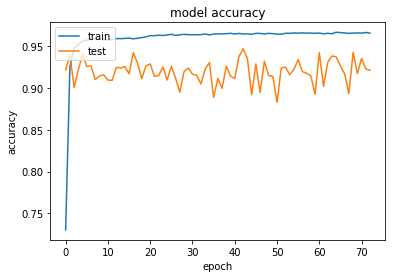

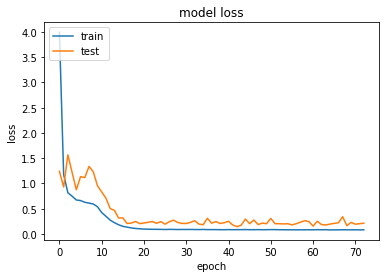

In [8]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
model_gpu.load_weights('../saved_models/fcn8_with_patches/model.hdf5')
model.save('../saved_models/fcn8_with_patches/model_saved.h5')

In [10]:
#valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE * gpus)
#test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE * gpus)